# note:
* [covariance matrix](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html)
* [multivariate_normal](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html)
* [seaborn  bivariate kernel density estimate](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.kdeplot.html#seaborn.kdeplot)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white", palette=sns.color_palette("RdBu"))

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats

import sys
sys.path.append('..')

from helper import anomaly

from sklearn.cross_validation import train_test_split

You want to divide data into 3 set. 
1. Training set
2. Cross Validation set
3. Test set.  

You shouldn't be doing prediction using training data or Validation data as it does in the exercise.

In [2]:
mat = sio.loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['X', '__version__', 'Xval', '__header__', '__globals__', 'yval'])

In [3]:
X = mat.get('X')

divide original validation data into validation and test set

In [4]:
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

Visualize training data

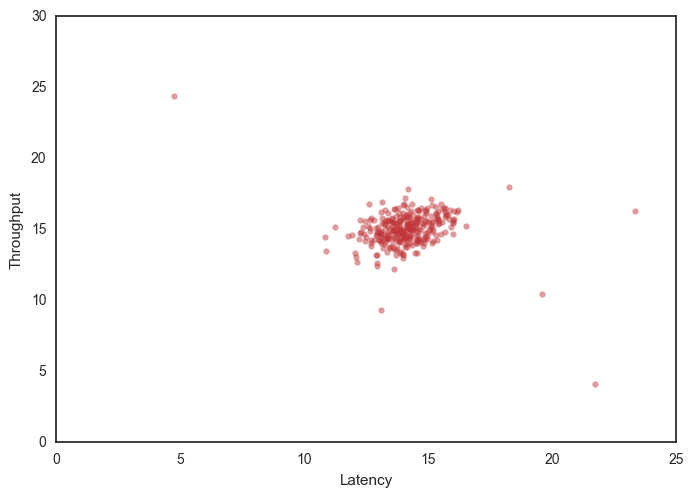

In [5]:
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           scatter_kws={"s":20,
                        "alpha":0.5})

# estimate multivariate Gaussian parameters $\mu$ and $\sigma^2$
> according to data, X1, and X2 is not independent

In [6]:
mu = X.mean(axis=0)
print(mu, '\n')

cov = np.cov(X.T)
print(cov)

[ 14.11222578  14.99771051] 

[[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


In [7]:
# example of creating 2d grid to calculate probability density
np.dstack(np.mgrid[0:3,0:3])

array([[[0, 0],
        [0, 1],
        [0, 2]],

       [[1, 0],
        [1, 1],
        [1, 2]],

       [[2, 0],
        [2, 1],
        [2, 2]]])

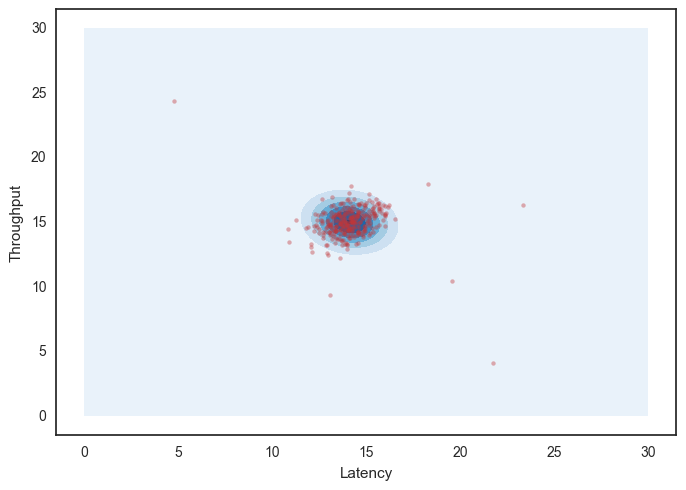

In [8]:
# create multi-var Gaussian model
multi_normal = stats.multivariate_normal(mu, cov)

# create a grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original data points
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           ax=ax,
           scatter_kws={"s":10,
                        "alpha":0.4})

# select threshold $\epsilon$
1. use training set $X$ to model the multivariate Gaussian
2. use cross validation set $(Xval, yval)$ to find the best $\epsilon$ by finding the best `F-score`

<img style="float: left;" src="../img/f1_score.png">

In [ ]:
def select_threshold(X, Xval, yval):
    """use CV data to find the best epsilon
    Returns:
        e: best epsilon with the highest f-score
        f-score: such best f-score
    """
    # create multivariate model using training data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)

    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    # calculate f-score
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))

    # find the best f-score
    argmax_fs = np.argmax(fs)

    return epsilon[argmax_fs], fs[argmax_fs]


In [9]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 2.8762918640653916e-05
Best F-score on validation data: 0.6666666666666666


# visualize prediction of `Xval` using learned $\epsilon$
1. use CV data to find the best $\epsilon$
2. use all data (training + validation) to create model
3. do the prediction on test data

In [10]:
multi_normal, y_pred = anomaly.predict(X, Xval, e, Xtest, ytest)

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       147
          1       1.00      0.86      0.92         7

avg / total       0.99      0.99      0.99       154



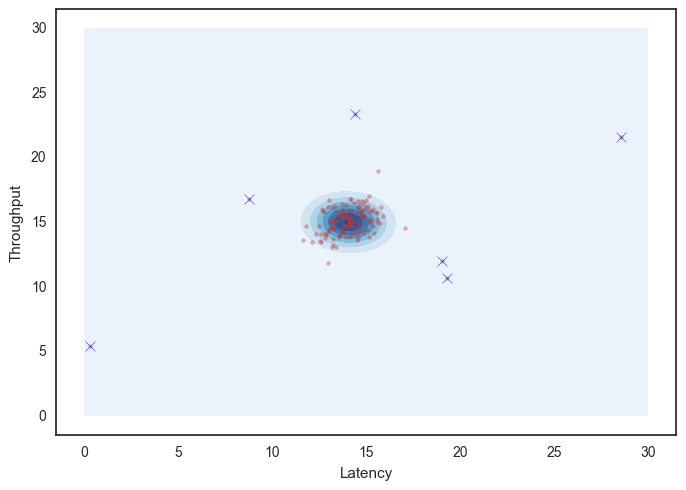

In [11]:
# construct test DataFrame
data = pd.DataFrame(Xtest, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

# create a grid for graphing
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original Xval points
sns.regplot('Latency', 'Throughput',
            data=data,
            fit_reg=False,
            ax=ax,
            scatter_kws={"s":10,
                         "alpha":0.4})

# mark the predicted anamoly of CV data. We should have a test set for this...
anamoly_data = data[data['y_pred']==1]
ax.scatter(anamoly_data['Latency'], anamoly_data['Throughput'], marker='x', s=50)

# high dimension data

In [12]:
mat = sio.loadmat('./data/ex8data2.mat')

In [13]:
X = mat.get('X')
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

In [14]:
e, fs = anomaly.select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 1.74667432759803e-19
Best F-score on validation data: 0.9090909090909091


In [15]:
multi_normal, y_pred = anomaly.predict(X, Xval, e, Xtest, ytest)

             precision    recall  f1-score   support

          0       0.96      0.96      0.96        46
          1       0.50      0.50      0.50         4

avg / total       0.92      0.92      0.92        50



In [16]:
print('find {} anamolies'.format(y_pred.sum()))

find 4 anamolies


The huge difference between my result, and the official `117` anamolies in the ex8 is due to:
1. my use of **multivariate Gaussian**
2. I split data very differently